<a href="https://colab.research.google.com/github/rebeckakarras/Lab3/blob/main/matb_project_withPCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Init
Handling dependancied and importing datasets

In [14]:
from google.colab import output
output.enable_custom_widget_manager()


In [15]:
try:
    import google.colab  # type: ignore # noqa: F401
    %pip install git+https://github.com/hackingmaterials/matbench
except ImportError:
    print("not in Colab")

  Cloning https://github.com/hackingmaterials/matbench to /tmp/pip-req-build-gcmf9kxe
  Running command git clone --filter=blob:none --quiet https://github.com/hackingmaterials/matbench /tmp/pip-req-build-gcmf9kxe
  Resolved https://github.com/hackingmaterials/matbench to commit 936176db18ca4cd7b38cbd957c017a5bac770c6b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [16]:
from matbench.bench import MatbenchBenchmark
mb = MatbenchBenchmark(autoload=False)

2024-10-14 08:21:05 INFO     Initialized benchmark 'matbench_v0.1' with 13 tasks: 
['matbench_dielectric',
 'matbench_expt_gap',
 'matbench_expt_is_metal',
 'matbench_glass',
 'matbench_jdft2d',
 'matbench_log_gvrh',
 'matbench_log_kvrh',
 'matbench_mp_e_form',
 'matbench_mp_gap',
 'matbench_mp_is_metal',
 'matbench_perovskites',
 'matbench_phonons',
 'matbench_steels']


INFO:matbench:Initialized benchmark 'matbench_v0.1' with 13 tasks: 
['matbench_dielectric',
 'matbench_expt_gap',
 'matbench_expt_is_metal',
 'matbench_glass',
 'matbench_jdft2d',
 'matbench_log_gvrh',
 'matbench_log_kvrh',
 'matbench_mp_e_form',
 'matbench_mp_gap',
 'matbench_mp_is_metal',
 'matbench_perovskites',
 'matbench_phonons',
 'matbench_steels']


In [17]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


# Get first task

In [58]:
for task in mb.tasks:
  if task.dataset_name == "matbench_phonons":
    print(task.dataset_name)
    break

mb.matbench_phonons.load()

for fold in task.folds:

      # Inputs are either chemical compositions as strings
      # or crystal structures as pymatgen.Structure objects.
      # Outputs are either floats (regression tasks) or bools (classification tasks)
      train_inputs, train_outputs = task.get_train_and_val_data(fold)

matbench_phonons
2024-10-14 08:38:19 INFO     Loading dataset 'matbench_phonons'...


INFO:matbench.task:Loading dataset 'matbench_phonons'...


Fetching matbench_phonons.json.gz from https://ml.materialsproject.org/projects/matbench_phonons.json.gz to /usr/local/lib/python3.10/dist-packages/matminer/datasets/matbench_phonons.json.gz


Fetching https://ml.materialsproject.org/projects/matbench_phonons.json.gz in MB: 0.4608MB [00:00, 163.40MB/s]                             


2024-10-14 08:38:21 INFO     Dataset 'matbench_phonons loaded.


INFO:matbench.task:Dataset 'matbench_phonons loaded.


In [89]:
#from pydoc import help  # can type in the python console `help(name of function)` to get the documentation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy import stats
from IPython.display import display, HTML

# figures inline in notebook
%matplotlib inline

np.set_printoptions(suppress=True)

DISPLAY_MAX_ROWS = 20  # number of max rows to print for a DataFrame
pd.set_option('display.max_rows', DISPLAY_MAX_ROWS)

# Prepare the data

In [59]:
type(train_inputs)

pandas.core.series.Series

In [60]:
train_inputs[1]

<ipython-input-60-1c8cd56008e5>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_inputs[1]


Structure Summary
Lattice
    abc : 4.3015 4.301499762381023 5.2703
 angles : 90.0 90.0 120.00000182735626
 volume : 84.45119345190359
      A : 4.3015 0.0 0.0
      B : -2.15075 3.725208 0.0
      C : 0.0 0.0 5.2703
    pbc : True True True
PeriodicSite: Ba (0.0, 0.0, 0.0) [0.0, 0.0, 0.0]
PeriodicSite: Ga (2.151, 1.242, 2.858) [0.6666, 0.3333, 0.5423]
PeriodicSite: Si (0.0002151, 2.484, 2.401) [0.3334, 0.6667, 0.4555]
PeriodicSite: H (2.151, 1.242, 4.616) [0.6666, 0.3333, 0.8759]

In [66]:
train_outputs[1]

<ipython-input-66-2c988c9362bf>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_outputs[1]


1138.5856886491724

In [104]:
def extract_features(structure_data):
    lattice_params = structure_data.lattice.abc
    angles = structure_data.lattice.angles
    volume = structure_data.lattice.volume

    # Extract atomic coordinates and species
    atomic_coords = [site.frac_coords for site in structure_data.sites]
    atomic_species = [site.specie.Z for site in structure_data.sites]

    # Flatten atomic coordinates
    atomic_coords_flat = np.array(atomic_coords).flatten()

    # Ensure both atomic coordinates and species are of length 288
    max_length = 288
    atomic_coords_padded = np.zeros(max_length)
    atomic_species_padded = np.zeros(max_length)

    # Fill in with actual values up to their original lengths
    atomic_coords_padded[:len(atomic_coords_flat)] = atomic_coords_flat[:min(len(atomic_coords_flat), max_length)]
    atomic_species_padded[:len(atomic_species)] = atomic_species[:min(len(atomic_species), max_length)]

    # Concatenate features
    features = np.concatenate([lattice_params, angles, [volume], atomic_coords_padded, atomic_species_padded])

    return features



X = np.array([extract_features(structure) for structure in train_inputs])
y = np.array(train_outputs)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [109]:
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Only transform the validation data (don't fit again)
X_val_scaled = scaler.transform(X_val)

In [111]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train_scaled)

# Get explained variance ratio for each component
explained_variance = pca.explained_variance_ratio_

# Compute cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Determine how many PCs are needed to explain at least 80% or 90% of the variance
num_components_80 = np.argmax(cumulative_variance >= 0.80) + 1
num_components_90 = np.argmax(cumulative_variance >= 0.90) + 1

print(f'Number of components to explain 80% of the variance: {num_components_80}')
print(f'Number of components to explain 90% of the variance: {num_components_90}')


Number of components to explain 80% of the variance: 16
Number of components to explain 90% of the variance: 29


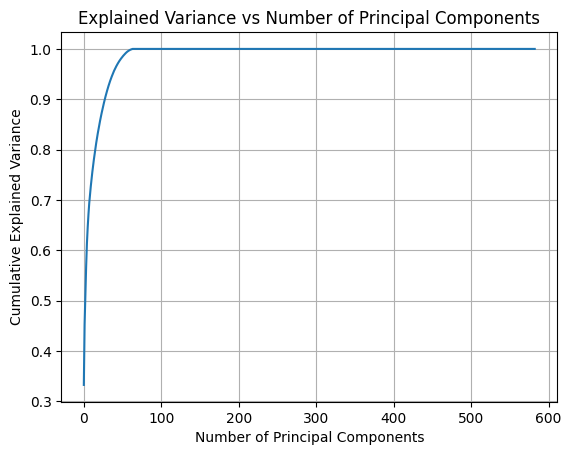

In [158]:
import matplotlib.pyplot as plt

# Plot cumulative explained variance
plt.plot(cumulative_variance)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Principal Components')
plt.grid(True)
plt.show()

In [159]:
pca = PCA(n_components=num_components_90)

# Fit PCA on the training data
X_train_pca = pca.fit_transform(X_train_scaled)

# Apply PCA transformation to the validation data
X_val_pca = pca.transform(X_val_scaled)

# The explained variance tells you how much variance is retained by each component
print(pca.explained_variance_ratio_)

[0.33254625 0.12007875 0.0604994  0.05484436 0.04571064 0.03189806
 0.02620659 0.02192965 0.01724135 0.01626118 0.01448645 0.01399906
 0.01280261 0.01212685 0.01140438 0.01098435 0.01024487 0.00969549
 0.00922971 0.00865542 0.0084102  0.00822929 0.0078095  0.00731238
 0.00715361 0.00672776 0.00667824 0.00640228 0.00593498]


In [164]:
X_train_pca = pca.transform(X_train_scaled)[:, :26]

# Train a machine learning model on the reduced data
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_pca, y_train)

# Similarly transform the validation set or test set and evaluate
X_val_pca = pca.transform(X_val_scaled)[:, :26]
val_score = model.score(X_val_pca, y_val)
print(f'Validation Score: {val_score}')

Validation Score: 0.3529250582284581


In [165]:
X.shape

(1012, 583)

In [68]:
y[0]

701.5857233477558

# ML

In [74]:
def build_model(input_shape):
    model = models.Sequential()
    model.add(layers.Dense(256, activation='relu', input_dim=583))#input_shape=(,7)))
    layers.Dropout(0.5),
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    #model.add(layers.Dense(1))  # Output layer for regression
    print(model.summary())
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

In [75]:
# Build and train the Keras model
model = build_model(X_train.shape[1])


history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Get test data and extract features
test_inputs = task.get_test_data(fold, include_target=False)
X_test = np.array([extract_features(structure) for structure in test_inputs])
X_test_scaled = scaler.transform(X_test)

# Predict on the testing data
predictions = model.predict(X_test_scaled)



train_loss = history.history["loss"][1:]
test_loss = history.history["val_loss"][1:]

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                     │ (None, 256)                 │         149,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 190,721 (745.00 KB)

 Trainable params: 190,721 (745.00 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 598795.0000 - mae: 577.9169 - val_loss: 543067.1250 - val_mae: 558.9317
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 573633.0625 - mae: 543.4976 - val_loss: 354681.6875 - val_mae: 382.4522
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 291688.1250 - mae: 323.4313 - val_loss: 191506.6406 - val_mae: 281.3502
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 161377.0938 - mae: 262.2943 - val_loss: 148773.3438 - val_mae: 234.0410
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 174780.3281 - mae: 243.4268 - val_loss: 138366.3125 - val_mae: 233.3213
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 160865.3125 - mae: 235.7124 - val_loss: 132549.7188 - val_mae: 229.9500
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 145280.6250 - mae: 228.6543 - val_loss: 129044.0625 - val_mae: 224.1329
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 184176.8125 - mae: 245.902

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


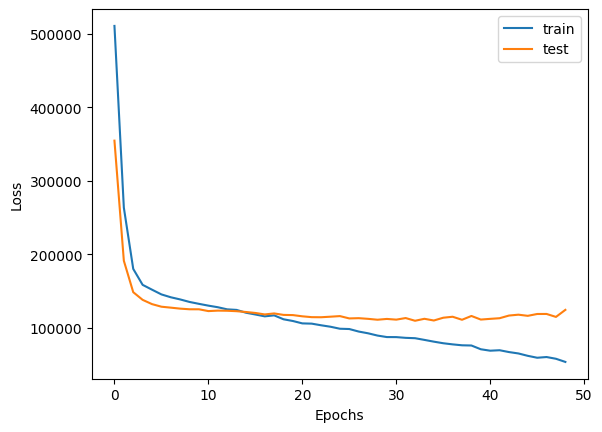

In [76]:
# Prepare and plot loss over time
plt.plot(train_loss,label="train")
plt.plot(test_loss,label="test")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()